Yalda Foroutan

https://github.com/Youlenda

**Hand Pose Classification**

Install Tensorflow, Keras and EfficientNet.

In [1]:
# !pip install q tensorflow==2.1
# !pip install q keras==2.3.1

In [2]:
# !pip install efficientnet

Import libraries.

In [3]:
import os
import glob 
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import keras
from keras import backend as k 
from keras.backend import sigmoid
from keras import applications
from keras import optimizers
from keras.optimizers import Adam
import efficientnet.keras as enet
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.utils.generic_utils import get_custom_objects
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, BatchNormalization, Activation

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


Download Dataset.

[Training Set](https://drive.google.com/file/d/1eo7kkq8zzrlWgcCcQh1Stkei_eZhIAbl/view?usp=sharing)


[Validation Set](https://drive.google.com/file/d/1sghCxu83xV_DIZ1qWA4eLg_-hAQh-Pxs/view?usp=sharing)

In [4]:
# !unzip trainining

In [5]:
# !unzip validation

In [6]:
#training

training_path = '/content/train'
validation_path = '/content/valid'

lookup = dict()
reverselookup = dict()
count = 0
for j in os.listdir(training_path):
    if not j.startswith('.'):
        lookup[j] = count
        reverselookup[count] = j
        count = count + 1
lookup

{'0': 2, '1': 3, '2': 1, '3': 0}

In [7]:
#training
x_train = []
y_train = []
datacount = 0
for i in range(0, 4):
    for j in os.listdir(training_path + '/' + str(i) + '/'):
        if not j.startswith('.'):
            count = 0
            img = Image.open(training_path + '/' + str(i) + '/' + j).convert('RGB')
            img = img.resize((70, 70))
            arr = np.array(img)
            x_train.append(arr) 
            count = count + 1
            y_values_t = np.full((count, 1), lookup[str(i)])
            y_train.append(y_values_t)
            datacount = datacount + count
x_train = np.array(x_train, dtype='float32')
y_train = np.array(y_train)
y_train = y_train.reshape(datacount)

In [8]:
#validation
x_val = []
y_val = []
datacount = 0
for i in range(0, 4):
    for j in os.listdir(validation_path + '/' + str(i) + '/'):
        if not j.startswith('.'):
            count = 0
            img = Image.open(validation_path + '/'  + str(i) + '/' + j).convert('RGB')
            img = img.resize((70, 70))
            arr = np.array(img)
            x_val.append(arr) 
            count = count + 1
            y_values_v = np.full((count, 1), lookup[str(i)])
            y_val.append(y_values_v)
            datacount = datacount + count
x_val = np.array(x_val, dtype='float32')
y_val = np.array(y_val)
y_val = y_val.reshape(datacount)

In [9]:
x_valid, x_test, y_valid, y_test = train_test_split(x_val, y_val, test_size=0.5, shuffle=True)

In [10]:
#training
y_train = to_categorical(y_train)
x_train = x_train/255
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2], 3))

#validation
y_valid = to_categorical(y_valid)
x_valid = x_valid/255
x_valid = x_valid.reshape((x_valid.shape[0], x_valid.shape[1], x_valid.shape[2], 3))

#test
y_test = to_categorical(y_test)
x_test = x_test/255
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], x_test.shape[2], 3))

In [11]:
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape, x_test.shape, y_test.shape

((5120, 70, 70, 3),
 (5120, 4),
 (800, 70, 70, 3),
 (800, 4),
 (800, 70, 70, 3),
 (800, 4))

In [12]:
class SwishActivation(Activation):
    
    def __init__(self, activation, **kwargs):
        super(SwishActivation, self).__init__(activation, **kwargs)
        self.__name__ = 'swish_act'

def swish_act(x, beta = 1):
    return (x * sigmoid(beta * x))

get_custom_objects().update({'swish_act': SwishActivation(swish_act)})

In [13]:
model = enet.EfficientNetB0(include_top=False, input_shape=(70, 70, 3), pooling='avg', weights='imagenet')

x = model.output

x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(512)(x)
x = BatchNormalization()(x)
x = Activation('swish_act')(x)
x = Dropout(0.5)(x)

x = Dense(256)(x)
x = Activation('swish_act')(x)

x = Dense(128)(x)
x = Activation('swish_act')(x)

x = Dense(64)(x)
x = Activation('swish_act')(x)

x = Dense(32)(x)
x = Activation('swish_act')(x)

x = Dense(16)(x)
x = Activation('swish_act')(x)

x = Dense(8)(x)
x = Activation('swish_act')(x)


# Output layer
predictions = Dense(4, activation='softmax')(x)
model_final = Model(inputs = model.input, outputs = predictions)

# model_final.summary()

In [14]:
model_final.compile(loss='categorical_crossentropy',
              optimizer=Adam(0.0001),
              metrics=['accuracy'])

mcp_save = ModelCheckpoint('Final_Model.h5', save_best_only=True, monitor='val_acc')
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2, verbose=1,)

history = model_final.fit(x_train, y_train,
                          batch_size=32,
                          epochs=20,
                          validation_data=[x_valid, y_valid],
                          callbacks=[mcp_save, reduce_lr],
                          shuffle=True,
                          verbose=1)

model_final.save('Final_Model.h5')
model_final.save_weights('Final_Model_Weight.h5')

Train on 5120 samples, validate on 800 samples
Epoch 1/20
5120/5120 [==============================] - 38s 7ms/step - loss: 0.8927 - accuracy: 0.6887 - val_loss: 0.4492 - val_accuracy: 0.9825
Epoch 2/20
  32/5120 [..............................] - ETA: 17s - loss: 0.2613 - accuracy: 0.9062

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


5120/5120 [==============================] - 19s 4ms/step - loss: 0.0968 - accuracy: 0.9729 - val_loss: 0.0491 - val_accuracy: 0.9987
Epoch 3/20
5120/5120 [==============================] - 19s 4ms/step - loss: 0.0459 - accuracy: 0.9877 - val_loss: 0.0095 - val_accuracy: 0.9987
Epoch 4/20
5120/5120 [==============================] - 19s 4ms/step - loss: 0.0317 - accuracy: 0.9918 - val_loss: 0.0260 - val_accuracy: 0.9900
Epoch 5/20
5120/5120 [==============================] - 19s 4ms/step - loss: 0.0151 - accuracy: 0.9963 - val_loss: 0.0611 - val_accuracy: 0.9825
Epoch 6/20
5120/5120 [==============================] - 19s 4ms/step - loss: 0.0129 - accuracy: 0.9967 - val_loss: 0.1171 - val_accuracy: 0.9488
Epoch 7/20
5120/5120 [==============================] - 19s 4ms/step - loss: 0.0164 - accuracy: 0.9959 - val_loss: 0.0451 - val_accuracy: 0.9862
Epoch 8/20
5120/5120 [==============================] - 19s 4ms/step - loss: 0.0136 - accuracy: 0.9971 - val_loss: 0.0618 - val_accuracy: 0.9

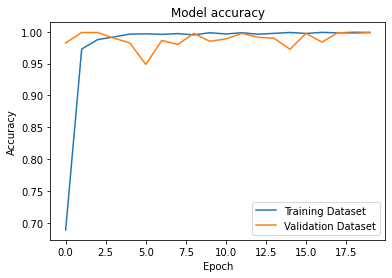

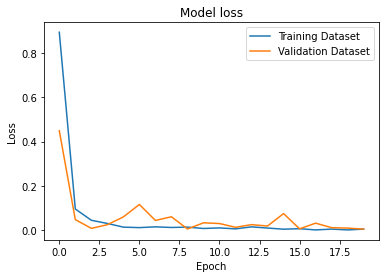

In [15]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Dataset', 'Validation Dataset'], loc='lower right')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Dataset', 'Validation Dataset'], loc='upper right')
plt.show()

In [28]:
_, acc = model_final.evaluate(x_test, y_test)
print('Test Accuracy: {}%'.format(acc*100))

800/800 [==============================] - 1s 761us/step
Test Accuracy: 100.0%


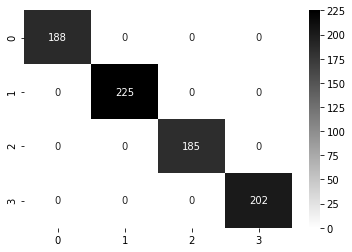

In [29]:
test_pred = model_final.predict(x_test)
ax = sns.heatmap(confusion_matrix(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1)), cmap='binary', annot=True, fmt='d')

In [30]:
test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow(x_test, y_test, shuffle=False)
predict_label = model_final.predict_generator(test_generator)

In [31]:
real_label = test_generator.y

In [32]:
count = 0
for i in range(0, 799):
    if (np.argmax(real_label[i]) != np.argmax(predict_label[i])):
      print(i)
      count = count + 1